In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from numba import jit, njit, cuda, prange
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.signal as ss
import scipy.integrate as si
import scipy.optimize

import time

(4001, 29, 2)


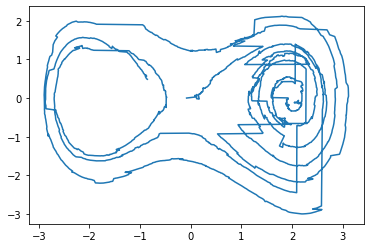

In [2]:
mctrajlist = []
for i in range(100):
    # fname = '/pscratch/sd/h/hbhat512/mcsoldblwell/mctrigdblwell2d' + str(i+1) + '.dat'
    fname = '/pscratch/sd/h/hbhat512/mcpolydblwell2d/mcpolydblwell2d' + str(i+1) + '.dat'
    # fname = '/tmp/mcpolydblwell2d/mcpolydblwell2d' + str(i+1) + '.dat'
    arr = np.fromfile(fname, dtype=np.float64).reshape((-1,2))
    if np.sum(np.abs(arr) <= 2*np.pi)==np.prod(np.array(arr.shape)):
        mctrajlist.append(arr)

mctraj = np.stack(mctrajlist, 1)
mctraj = mctraj[::100,:,:]
print(mctraj.shape)

plt.plot(mctraj[:,0,0],mctraj[:,0,1])
plt.show()

In [3]:
dilfac = 100
mctraj = mctraj[::dilfac,:]
#plt.plot(mctraj)
#plt.show()
numtraj = mctraj.shape[1]
lentraj = mctraj.shape[0]
print(mctraj.shape)

(41, 29, 2)


In [4]:
# time step of the data
deltat = 0.01*dilfac

# crucial parameter that sets internal time step
numsteps = dilfac
h = deltat/numsteps

# constant diffusion
g = 0.1

# levy alpha parameter
alpha = 1.0

# take L = 2
bigL = 2

# set n2, number of points to the left of the origin
n2 = 32
npts = 2*n2 + 1
nplot = npts
xplot = np.linspace(-2*np.pi, 2*np.pi, nplot+1)
xplot = xplot[:nplot]
xp1, xp2 = np.meshgrid(xplot, xplot)

# number of modes to keep track of in theta
# used bigJ = 4 for sin2d
bigJ = 8

# take n_L = 2
nL = 4
ds = 1.0/(bigL*nL)
uvec = np.arange(-n2,n2+1)*ds
umin = np.amin(uvec)
umax = np.amax(uvec)

U1, U2 = np.meshgrid(uvec, uvec)

print([ds, umin, umax])


[0.125, -4.0, 4.0]


In [5]:
# now construct f on a plotting grid
@njit
def represent(theta, JJ):
    f1 = np.zeros((nplot, nplot), dtype=np.complex128)
    f2 = np.zeros((nplot, nplot), dtype=np.complex128)    
    modes = np.arange(-JJ,JJ+1)/bigL
    for j1 in range(2*JJ+1):
        for j2 in range(2*JJ+1):
            f1 += theta[j1, j2, 0]*np.exp(1j*(xp1*modes[j1] + xp2*modes[j2]))
            f2 += theta[j1, j2, 1]*np.exp(1j*(xp1*modes[j1] + xp2*modes[j2]))
    
    return f1, f2

# now construct f on a plotting grid
# low-dimensional version
@njit
def LDrepresent(theta, JJ):
    f1 = np.zeros((nplot, nplot), dtype=np.complex128)
    f2 = np.zeros((nplot, nplot), dtype=np.complex128)
    modes = np.arange(-JJ,JJ+1)/bigL
    for j2 in range(2*JJ+1):
        f1 += theta[JJ, j2, 0]*np.exp(1j*(xp1*modes[JJ] + xp2*modes[j2]))
    
    for j1 in range(2*JJ+1):
        f2 += theta[j1, JJ, 1]*np.exp(1j*(xp1*modes[j1] + xp2*modes[JJ]))
    
    return f1, f2

In [6]:
@njit(parallel=True)
def empiricalcharfun(mc):
    sig2 = 0.50**2
    psi = np.zeros((numtraj,lentraj,npts,npts), dtype=np.complex128)
    for kk in prange(lentraj):
        for ii in prange(npts):
            for jj in prange(npts):
                psi[:,kk,ii,jj] = np.exp(1j*(uvec[ii]*mc[kk,:,0]+uvec[jj]*mc[kk,:,1])- 0.5*sig2*(uvec[ii]**2 + uvec[jj]**2))
    return psi


In [7]:
psiall = empiricalcharfun(mctraj)
print(psiall.shape)

# initial char fun
psi0 = psiall[:,:-1,:,:].reshape((-1,npts,npts))
print(psi0.shape)

# target char fun
psitarget = psiall[:,1:,:,:].reshape((-1,npts,npts))
print(psitarget.shape)

# first axis in newpsi and oldpsi refers to the batching dimension
lentraj = psi0.shape[0]
batchsize = 400
numbatches = int(np.ceil(lentraj/batchsize))
print(numbatches)
print(numbatches*batchsize)

# need this guy to propagate
diagfac = np.exp(-h*np.abs((U1 + U2)*g)**alpha)
print(diagfac.shape)

ddiagfac = cuda.to_device(diagfac)

(29, 41, 65, 65)
(1160, 65, 65)
(1160, 65, 65)
3
1200
(65, 65)


In [8]:
@cuda.jit('void(complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:,:], float64[:,:], int32)')
def update(newpsi, oldpsi, dtheta, dtheta2, ddiagfac, tbatchsize):
    m, j1, j2 = cuda.grid(3)
    if m < tbatchsize and j1 < npts and j2 < npts:
        term11 = 0.0
        term12 = 0.0
        truej1 = j1 - n2
        truej2 = j2 - n2
        for jp1 in range(2*bigJ+1):
            for jp2 in range(2*bigJ+1):
                if abs(truej1 + (jp1-bigJ)*nL) <= n2 and abs(truej2 + (jp2-bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (jp1-bigJ)*nL, j2 + (jp2-bigJ)*nL]
                    term11 += dtheta[jp1, jp2, 0]*tmp
                    term12 += dtheta[jp1, jp2, 1]*tmp
                    
        term211 = 0.0
        term212 = 0.0
        term221 = 0.0
        term222 = 0.0
        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                if abs(truej1 + (k1-2*bigJ)*nL) <= n2 and abs(truej2 + (k2-2*bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (k1-2*bigJ)*nL, j2 + (k2-2*bigJ)*nL]
                    term211 += dtheta2[k1, k2, 0, 0]*tmp
                    term212 += dtheta2[k1, k2, 0, 1]*tmp
                    term221 += dtheta2[k1, k2, 1, 0]*tmp
                    term222 += dtheta2[k1, k2, 1, 1]*tmp
        newpsi[m, j1, j2] += 1j*(h*ds)*(truej1*term11 + truej2*term12)
        newpsi[m, j1, j2] += -0.5*((h*ds)**2)*(term211*truej1**2 + (term212+term221)*truej1*truej2 + term222*truej2**2)
        newpsi[m, j1, j2] *= ddiagfac[j1, j2] # math.exp(-h*ds*g*abs(truej1+truej2)**alpha)

In [9]:
@cuda.jit
def copyover(newpsi, oldpsi, tbatchsize):
    m, i, j = cuda.grid(3)
    if m < tbatchsize and i < npts and j < npts:
        oldpsi[m,i,j] = newpsi[m,i,j]

In [10]:
def MMDlossGPU(theta):
    theta2 = np.zeros((4*bigJ+1, 4*bigJ+1, 2, 2), dtype=np.complex128)
    for i in range(2):
        for j in range(2):
            theta2[:,:,i,j] = ss.convolve(theta[:,:,i], theta[:,:,j])
    
    dtheta = cuda.to_device(theta)
    dtheta2 = cuda.to_device(theta2)
    
    threadsperblock = (8,8,8) # try 8, 10, 10
    blockspergrid_x = int(np.ceil(batchsize / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(npts / threadsperblock[1]))
    blockspergrid_z = int(np.ceil(npts / threadsperblock[2]))
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
    loss = 0.0
    for batch in range(numbatches):
        if batch==(numbatches-1):
            thisbatch = np.arange(batch*batchsize, lentraj, dtype=np.int32)
            tbatchsize = lentraj - (batch*batchsize)
        else:
            thisbatch = np.arange(batch*batchsize, (batch+1)*batchsize, dtype=np.int32)
            tbatchsize = batchsize
        print([thisbatch[0], thisbatch[-1]])
        doldpsi = cuda.to_device(psi0[thisbatch,:,:])
        dnewpsi = cuda.to_device(psi0[thisbatch,:,:])
        for k in range(numsteps):
            update[blockspergrid, threadsperblock](dnewpsi, doldpsi, dtheta, dtheta2, ddiagfac, tbatchsize)
            copyover[blockspergrid, threadsperblock](dnewpsi, doldpsi, tbatchsize)
        psifinal = dnewpsi.copy_to_host() 
        loss += 0.5*np.sum(np.square(np.abs(psifinal - psitarget[thisbatch,:,:])))
    
    return loss/(lentraj-1)

In [11]:
@cuda.jit('void(complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:,:], float64[:,:], int32)')
def updatev2(newpsi, oldpsi, dtheta, dtheta2, ddiagfac, tbatchsize):
    m, j1, j2 = cuda.grid(3)
    if m < tbatchsize and j1 < npts and j2 < npts:
        term11 = 0.0
        term12 = 0.0
        truej1 = j1 - n2
        truej2 = j2 - n2
        for jp1 in range(2*bigJ+1):
            for jp2 in range(2*bigJ+1):
                if abs(truej1 + (jp1-bigJ)*nL) <= n2 and abs(truej2 + (jp2-bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (jp1-bigJ)*nL, j2 + (jp2-bigJ)*nL]
                    term11 += dtheta[jp1, jp2, 0]*tmp
                    term12 += dtheta[jp1, jp2, 1]*tmp
                    
        term211 = 0.0
        term212 = 0.0
        term221 = 0.0
        term222 = 0.0
        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                if abs(truej1 + (k1-2*bigJ)*nL) <= n2 and abs(truej2 + (k2-2*bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (k1-2*bigJ)*nL, j2 + (k2-2*bigJ)*nL]
                    term211 += dtheta2[k1, k2, 0, 0]*tmp
                    term212 += dtheta2[k1, k2, 0, 1]*tmp
                    term221 += dtheta2[k1, k2, 1, 0]*tmp
                    term222 += dtheta2[k1, k2, 1, 1]*tmp
        newpsi[m, j1, j2] = oldpsi[m, j1, j2]
        newpsi[m, j1, j2] += 1j*(h*ds)*(truej1*term11 + truej2*term12)
        newpsi[m, j1, j2] += -0.5*((h*ds)**2)*(term211*truej1**2 + (term212+term221)*truej1*truej2 + term222*truej2**2)
        newpsi[m, j1, j2] *= ddiagfac[j1, j2] # math.exp(-h*ds*g*abs(truej1+truej2)**alpha)

In [12]:
# let us assume that oldlamb is of size (npts, npts)
# we need to compute newlamb of the same size

@cuda.jit('void(complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:,:], float64[:,:], int32)')
def GPUlambda(newlamb, oldlamb, theta, theta2, diagfac, tbatchsize):
    m, l1, l2 = cuda.grid(3)
    if m < tbatchsize and l1 < npts and l2 < npts:
        newlamb[m,l1,l2] = oldlamb[m,l1,l2]*diagfac[l1,l2]
        truel1 = l1 - n2
        truel2 = l2 - n2
        for k1 in range(2*bigJ+1):
            for k2 in range(2*bigJ+1):
                truek1 = k1 - bigJ
                truek2 = k2 - bigJ
                ind1 = truel1 - truek1*nL
                ind2 = truel2 - truek2*nL
                if abs(ind1)<=n2 and abs(ind2)<=n2:
                    dd = diagfac[ind1+n2,ind2+n2]
                    newlamb[m,l1,l2] += dd*1j*(h*ds)*oldlamb[m,ind1+n2,ind2+n2]*(ind1*theta[k1,k2,0]+ind2*theta[k1,k2,1])
        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                truek1 = k1 - 2*bigJ
                truek2 = k2 - 2*bigJ
                ind1 = truel1 - truek1*nL
                ind2 = truel2 - truek2*nL
                if abs(ind1)<=n2 and abs(ind2)<=n2:
                    term211 = theta2[k1, k2, 0, 0]
                    term212 = theta2[k1, k2, 0, 1]
                    term221 = theta2[k1, k2, 1, 0]
                    term222 = theta2[k1, k2, 1, 1]
                    dd = diagfac[ind1+n2,ind2+n2]
                    newlamb[m,l1,l2] -= dd*0.5*(h*ds)**2*oldlamb[m,ind1+n2,ind2+n2]*(term211*ind1**2 + (term212+term221)*ind1*ind2 + term222*ind2**2)


In [13]:
@cuda.jit('void(complex128[:,:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], float64[:,:], int32, int32, int32)')
def derivreduce3(psi1, lamb0conj, psi0, theta, diagfac, r1, r2, tbatchsize):
    m, j1, j2 = cuda.grid(3)
    if m < tbatchsize*numsteps and j1 < npts and j2 < npts:
        out0 = 0.0
        out1 = 0.0
        truej1 = j1 - n2
        truej2 = j2 - n2
        lambvalconj = lamb0conj[m, j1, j2]
        truer1 = r1 - bigJ
        truer2 = r2 - bigJ
        if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
            tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
            overall = lambvalconj*1j*(h*ds)*diagfac[j1,j2]*tmp
            out0 += overall*truej1
            out1 += overall*truej2

        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                truek1 = k1 - 2*bigJ
                truek2 = k2 - 2*bigJ
                if abs(truek1-truer1) <= bigJ and abs(truek2-truer2) <= bigJ:
                    if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
                        tmp2 = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
                        term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
                        term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
                        overall2 = -lambvalconj*((h*ds)**2)*(term21 * truej1 + term22 * truej2)*tmp2*diagfac[j1,j2]
                        out0 += overall2*truej1
                        out1 += overall2*truej2
        
        psi1[0,m,j1,j2] = out0
        psi1[1,m,j1,j2] = out1

In [14]:
@cuda.reduce
def sum_reduce(a, b):
    return a + b

In [15]:
@cuda.jit('void(complex128[:,:,:,:], complex128[:,:,:], int32)')
def myassign(outarr, inarr, ind):
    m, j1, j2 = cuda.grid(3)
    if m < batchsize and j1 < npts and j2 < npts:
        outarr[ind,m,j1,j2] = inarr[m,j1,j2]


In [16]:
# need to minibatch this!
# can handle only a certain number of steps at once

# adjoint method
def MMDadjGPUv2(theta):
    theta2 = np.zeros((4*bigJ+1, 4*bigJ+1, 2, 2), dtype=np.complex128)
    for i in range(2):
        for j in range(2):
            theta2[:,:,i,j] = ss.convolve(theta[:,:,i], theta[:,:,j])
    
    dtheta = cuda.to_device(theta)
    dtheta2 = cuda.to_device(theta2)
    
    threadsperblock = (8,8,8)
    blockspergrid_x = int(np.ceil(batchsize / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(npts / threadsperblock[1]))
    blockspergrid_z = int(np.ceil(npts / threadsperblock[2]))
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
    Dthreadsperblock = (8,8,8)
    Dblockspergrid_x = int(np.ceil(batchsize*numsteps / Dthreadsperblock[0]))
    Dblockspergrid_y = int(np.ceil(npts / Dthreadsperblock[1]))
    Dblockspergrid_z = int(np.ceil(npts / Dthreadsperblock[2]))
    Dblockspergrid = (Dblockspergrid_x, Dblockspergrid_y, Dblockspergrid_z)
    
    # do the entire trajectory sequentially
    loss = 0.0
    derivmat = np.zeros((2*bigJ+1,2*bigJ+1,2), dtype=np.complex128)
    for batch in range(numbatches):
        if batch==(numbatches-1):
            thisbatch = np.arange(batch*batchsize, lentraj, dtype=np.int32)
            tbatchsize = lentraj - batch*batchsize
        else:
            thisbatch = np.arange(batch*batchsize, (batch+1)*batchsize, dtype=np.int32)
            tbatchsize = batchsize
        ddu = cuda.to_device(np.zeros((2,tbatchsize*numsteps, npts, npts), dtype=np.complex128))
        psimat = np.zeros((numsteps+1, tbatchsize, npts, npts), dtype=np.complex128)
        psimat[0,:,:,:] = psi0[thisbatch,:,:]
        dpsimat = cuda.to_device(psimat)
        
        # dpsi0 = cuda.to_device(psi0[thisbatch,:,:])
        # myassign[blockspergrid, threadsperblock](dpsimat, dpsi0, 0)
        
        for k in range(numsteps):
            updatev2[blockspergrid, threadsperblock](dpsimat[k+1,:,:,:], dpsimat[k,:,:,:], dtheta, dtheta2, ddiagfac, tbatchsize)
        
        psimat = dpsimat.copy_to_host()
        resid = psimat[-1,:,:,:] - psitarget[thisbatch,:,:]
        loss += 0.5*np.sum(np.square(np.abs(resid)))/(lentraj-1)
        
        # everybody
        lambmat = np.zeros((numsteps+1, tbatchsize, npts, npts), dtype=np.complex128)
        lambmat[numsteps, :, :, :] = resid
        dlambmat = cuda.to_device(lambmat)
        
        # dresid = cuda.to_device(resid)
        # myassign[blockspergrid, threadsperblock](dlambmat, dresid, numsteps)
        
        for j in range(numsteps,0,-1):
            GPUlambda[blockspergrid, threadsperblock](dlambmat[j-1,:,:,:], dlambmat[j,:,:,:], dtheta, dtheta2, ddiagfac, tbatchsize)
        
        lambmat = dlambmat.copy_to_host()
        alllamb = lambmat[1:,:,:,:].reshape((tbatchsize*numsteps,npts,npts))
        dlambconj = cuda.to_device(np.conj(alllamb))
        allpsi = psimat[:-1,:,:,:].reshape((tbatchsize*numsteps,npts,npts))
        dpsi = cuda.to_device(allpsi)
        
        for r1 in range(2*bigJ+1):
            for r2 in range(2*bigJ+1):
                # du = CPUderivreduce3(alllamb, allpsi, theta, diagfac, r1, r2)
                # derivmat[r1,r2,0] += np.sum(du[0])
                # derivmat[r1,r2,1] += np.sum(du[1])
                derivreduce3[Dblockspergrid, Dthreadsperblock](ddu, dlambconj, dpsi, dtheta, ddiagfac, r1, r2, tbatchsize)
                mysum0 = sum_reduce(ddu[0,:,:,:].ravel())
                derivmat[r1, r2, 0] += mysum0
                mysum1 = sum_reduce(ddu[1,:,:,:].ravel())
                derivmat[r1, r2, 1] += mysum1
                        
            # du = derivupdate(theta, dpsimat[j,:,:,:].copy_to_host())
            # du = ddu.copy_to_host()
            # derivmat += therealdu
        
    return loss, derivmat/(lentraj-1)

In [17]:
def symmetrize(thetain):
    theta = np.copy(thetain)
    for truej1 in range(-bigJ, bigJ+1):
        for truej2 in range(-bigJ, bigJ+1):
            j1 = truej1 + bigJ
            j2 = truej2 + bigJ
            rj1 = -truej1 + bigJ
            rj2 = -truej2 + bigJ
            if truej1 + truej2 < 0:
                theta[j1, j2, :] = np.conj(theta[rj1, rj2, :])
            elif truej1 < 0 and truej2 == -truej1:
                theta[j1, j2, :] = np.conj(theta[rj1, rj2, :])
    
    theta[bigJ, bigJ, :] = np.real(theta[bigJ, bigJ, :])
    return theta

In [18]:
numparams = 2*(2*bigJ+1)**2
print(numparams)

def objgrad(thetaR):
    theta = thetaR[:numparams] + 1j*thetaR[numparams:]
    theta = theta.reshape((2*bigJ+1, 2*bigJ+1, 2))
    theta = symmetrize(theta)
    
    obj, grad = MMDadjGPUv2(theta)
    grad = symmetrize(grad)
    gradR = np.real(grad)
    gradI = -np.imag(grad)
    outgrad = np.concatenate([gradR.reshape((-1)), gradI.reshape((-1))])
    # regularization
    mu = 1.0
    obj += mu*np.sum(np.abs(thetaR))
    outgrad += mu*np.sign(thetaR)
    return obj, outgrad



578


In [19]:
# theta0 = np.load('finallearnedtheta.npz')['learnedtheta']
# theta0r = np.concatenate([np.real(theta0.reshape((-1))), np.imag(theta0.reshape((-1)))])

# theta0r = np.zeros(2*numparams)
# theta0 = theta0r[:numparams] + 1j*theta0r[numparams:]
# theta0 = theta0.reshape((2*bigJ+1, 2*bigJ+1, 2))

resx = np.load('polyn32J8dblwellNov22sig0.50.npz')['learnedtheta']
theta0 = resx[:numparams] + 1j*resx[numparams:]
theta0 = theta0.reshape((2*bigJ+1, 2*bigJ+1, 2))
theta0 = symmetrize(theta0)
theta0r = resx

print(MMDlossGPU(theta0))

[0, 399]
[400, 799]
[800, 1159]
218.2568494849279


In [22]:
def mycb(xk, state):
    np.savez('polyn32J8dblwellNov22sig0.50.npz',learnedtheta=xk)

In [23]:
res = scipy.optimize.minimize(fun=objgrad, x0=theta0r, jac=True, method='trust-constr', 
                              hess=scipy.optimize.SR1(), callback=mycb,
                              options={'gtol': 1e-3, 'xtol': 1e-3, 'verbose': 2,
                                       'initial_tr_radius': 6.16e-3})

/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +2.3288e+02 | 6.16e-03 | 2.07e+00 | 0.00e+00 |
|   2   |   2   |   1   | +2.3288e+02 | 3.08e-03 | 2.07e+00 | 0.00e+00 |
|   3   |   3   |   3   | +2.3287e+02 | 3.08e-03 | 2.28e+00 | 0.00e+00 |
|   4   |   4   |   5   | +2.3287e+02 | 3.08e-03 | 3.28e+00 | 0.00e+00 |
|   5   |   5   |   7   | +2.3287e+02 | 9.54e-04 | 3.28e+00 | 0.00e+00 |

`xtol` termination condition is satisfied.
Number of iterations: 5, function evaluations: 5, CG iterations: 7, optimality: 3.28e+00, constraint violation: 0.00e+00, execution time: 2e+03 s.


In [24]:
resx = res.x
theta0 = resx[:numparams] + 1j*resx[numparams:]
theta0 = theta0.reshape((2*bigJ+1, 2*bigJ+1, 2))
theta0 = symmetrize(theta0)

In [20]:
myfunc = represent(theta0, bigJ)

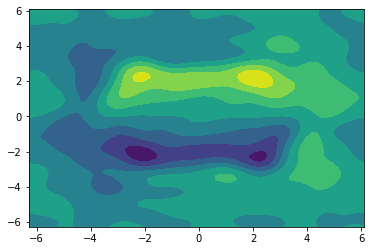

In [21]:
plt.contourf(xplot,xplot,np.real(myfunc[0]))
plt.show()

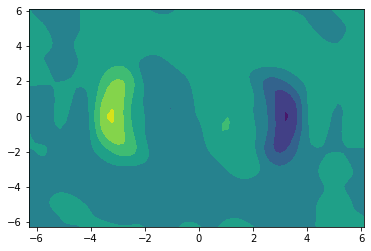

In [22]:
plt.contourf(xplot,xplot,np.real(myfunc[1]))
plt.show()

(-4.0, 4.0)

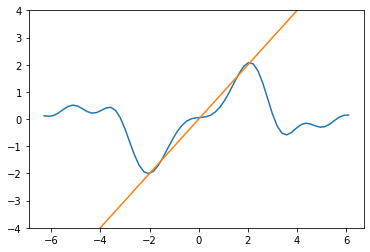

In [23]:
plt.plot(xplot,np.real(myfunc[0])[:,32])
plt.plot(xplot,xplot)
plt.ylim([-4,4])

(-6.0, 6.0)

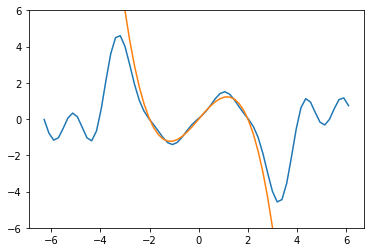

In [24]:
plt.plot(xplot,np.real(myfunc[1])[32,:])
plt.plot(xplot,0.4*xplot*(4-xplot**2))
plt.ylim([-6,6])

In [25]:
# now construct f on a plotting grid
@njit
def vectorfield(x, theta, JJ):
    f1 = 0.0
    f2 = 0.0
    modes = np.arange(-JJ,JJ+1)/bigL
    for j1 in range(2*JJ+1):
        for j2 in range(2*JJ+1):
            f1 += theta[j1, j2, 0]*np.exp(1j*(x[0]*modes[j1] + x[1]*modes[j2]))
            f2 += theta[j1, j2, 1]*np.exp(1j*(x[0]*modes[j1] + x[1]*modes[j2]))
    
    return np.array([np.real(f1), np.real(f2)])

In [26]:
def learnedvf(t, x):
    return vectorfield(x, theta0, bigJ)

def gtvf(t, x):
    return np.array([x[1], 0.4*x[0]*(4-x[0]**2) - x[1]/4.0])

In [27]:
# function to produce one ground truth trajectory
# y0 : initial condition
# tf : final time
# npts : number of time points at which to record solution

def gttraj(vf, y0, tf, npts):
    t_span = np.array([0., tf])
    t_eval = np.linspace(0,tf,npts)
    # solve ODE numerically
    sol = si.solve_ivp(vf, t_span=t_span, y0=y0, t_eval=t_eval, atol=1e-9, rtol=1e-9)
    return sol.y

In [30]:
# for a grid of initial conditions, generate trajectories
matplotlib.use('Agg')
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 20}
matplotlib.rc('font', **font)

plt.figure(figsize=(8,6))

xL = 2.0
nx = 5
xgrid = np.linspace(-xL, xL, nx)
ny = 7
ygrid = np.linspace(-xL, xL, ny)
alltraj = []
for i in range(nx):
    for j in range(ny):
        thistraj = gttraj(gtvf, np.array([xgrid[i], ygrid[j]]), 10.0, 5000)
        plt.plot(thistraj[0,:],thistraj[1,:])
        alltraj.append(thistraj)

plt.xlabel('$x_1(t)$')
plt.gca().yaxis.set_label_coords(-0.075,1.0)
plt.ylabel('$x_2(t)$')
plt.xlim([-np.pi, np.pi])
plt.ylim([-2.5,2.5])
plt.savefig('polydblwellGT.pdf')
plt.close()

In [31]:
# for a grid of initial conditions, generate trajectories
matplotlib.use('Agg')
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 20}
matplotlib.rc('font', **font)

plt.figure(figsize=(8,6))
xL = 2.0
nx = 5
xgrid = np.linspace(-xL, xL, nx)
ny = 7
ygrid = np.linspace(-xL, xL, ny)
alltraj = []
for i in range(nx):
    for j in range(ny):
        thistraj = gttraj(learnedvf, np.array([xgrid[i], ygrid[j]]), 10.0, 5000)
        plt.plot(thistraj[0,:],thistraj[1,:])
        alltraj.append(thistraj)

plt.xlabel('$x_1(t)$')
plt.gca().yaxis.set_label_coords(-0.075,1.0)
plt.ylabel('$x_2(t)$')
plt.xlim([-np.pi, np.pi])
plt.ylim([-2.5,2.5])
plt.savefig('polydblwellLEARNED.pdf')
plt.close()